In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import json
import datetime
import pandas as pd
import numpy as np

from pprint import pprint

with open('./data/Chrome/BrowserHistory-Gmail.json') as data_file:    
    data = json.load(data_file)

chrome_df = pd.DataFrame(data["Browser History"])

In [2]:
### Make these dates usable

In [53]:
def get_month_day_hour(timestamp):
    date = datetime.date.fromtimestamp(timestamp)

    return (date.strftime('%b'), int(date.strftime('%-d')), int(date.strftime('%Y')), date.strftime('%a'), date.strftime('%-H'))

chrome_df['timestamp'] = (chrome_df['time_usec']/1000000).astype(int) # in microseconds
chrome_df['month'], chrome_df['day'], chrome_df['year'], chrome_df['day_of_week'], chrome_df['hour'] = zip(*chrome_df["timestamp"].map(get_month_day_hour))

In [4]:
### Filter urls

In [17]:
chrome_df['site'] = chrome_df['url'].str.extract('\.(\w+)(?:\.com|\.org|\.net|\.co)')

In [19]:
### Plot some data
len(chrome_df.index)

678

In [18]:
chrome_df['site'].value_counts().sort_values(ascending=False).head(20)

tradesy         130
facebook         80
google           53
yahoo            41
splunkcloud       5
homedepot         3
splunk            2
faceook           2
ycombinator       2
w3                1
happyreturns      1
smartdatanow      1
att               1
Name: site, dtype: int64

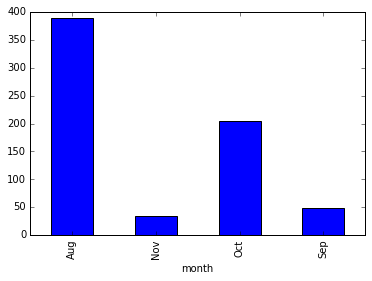

In [42]:
chrome_df[['month', 'client_id']].groupby("month").agg(['count']).plot(kind="bar", legend=False)

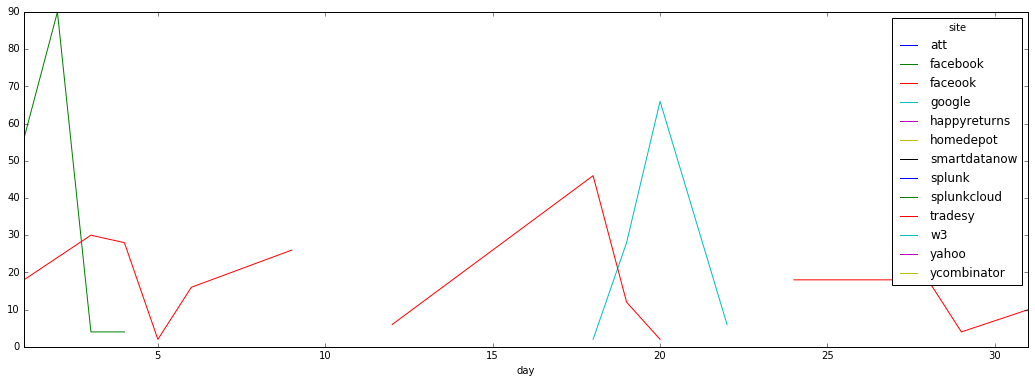

In [81]:
#chrome_df.groupby("site").plot(kind="line", x="day", sharex=True)
pd.pivot_table(chrome_df[['site', 'day']], columns='site', index='day', aggfunc=np.count_nonzero).plot(figsize=(18,6))

In [82]:
## Lets run a test
### Just for fun

In [84]:
"""
I have a hypothesis...

I think that its more likely that i browse recreational websites on Friday, rather than Monday or other workdays
"""

'\nI have a hypothesis...\n\nI think that its more likely that i browse recreational websites on Friday, rather than Monday or other workdays\n'